# Warehouse Location Analysis

---

Name : Riki  
Batch : HCK-019

## Import Libraries

In [ ]:
# preparation
!pip install -q geopandas
!pip install -q geopy

In [ ]:
# DataFrame and Data Manipulation
import pandas as pd
import numpy as np

# Geopandas and geopy
import geopandas as gpd
from geopy.geocoders import Nominatim

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import scaler
from sklearn.preprocessing import StandardScaler

# model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Connect to BigQuery

In [ ]:
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
client = bigquery.Client(project='watchful-scope-412407')

## Data Loading

In [ ]:
data = client.query('''

SELECT
  *
FROM `bigquery-public-data.thelook_ecommerce.users`
WHERE country = 'United States' and state <> 'Hawaii'

''').to_dataframe()

data.head()

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,2389,Dan,Martinez,danmartinez@example.net,53,M,Alabama,36226 Natalie Club,36608,Mobile,United States,30.680531,-88.294751,Organic,2020-08-31 07:25:00+00:00
1,3647,Danielle,Anderson,danielleanderson@example.com,31,F,Alabama,60522 Patrick Port Apt. 651,36608,Mobile,United States,30.680531,-88.294751,Search,2019-03-31 09:03:00+00:00
2,5280,Audrey,Alvarez,audreyalvarez@example.net,66,F,Alabama,31275 Veronica Knolls,36608,Mobile,United States,30.680531,-88.294751,Search,2022-06-18 15:08:00+00:00
3,8007,Megan,Perez,meganperez@example.net,47,F,Alabama,95116 Patrick Vista Apt. 936,36608,Mobile,United States,30.680531,-88.294751,Search,2023-09-23 15:49:00+00:00
4,20629,Rebecca,Henderson,rebeccahenderson@example.net,70,F,Alabama,71084 Donna Greens Apt. 802,36608,Mobile,United States,30.680531,-88.294751,Search,2021-04-02 08:33:00+00:00


## Map Visualization

In [ ]:
# define variable
map = gpd.read_file('https://raw.githubusercontent.com/wri/wri-bounds/master/dist/all_countries.geojson')

# select USA map
map = map[map['name']=='United States of America']['geometry']

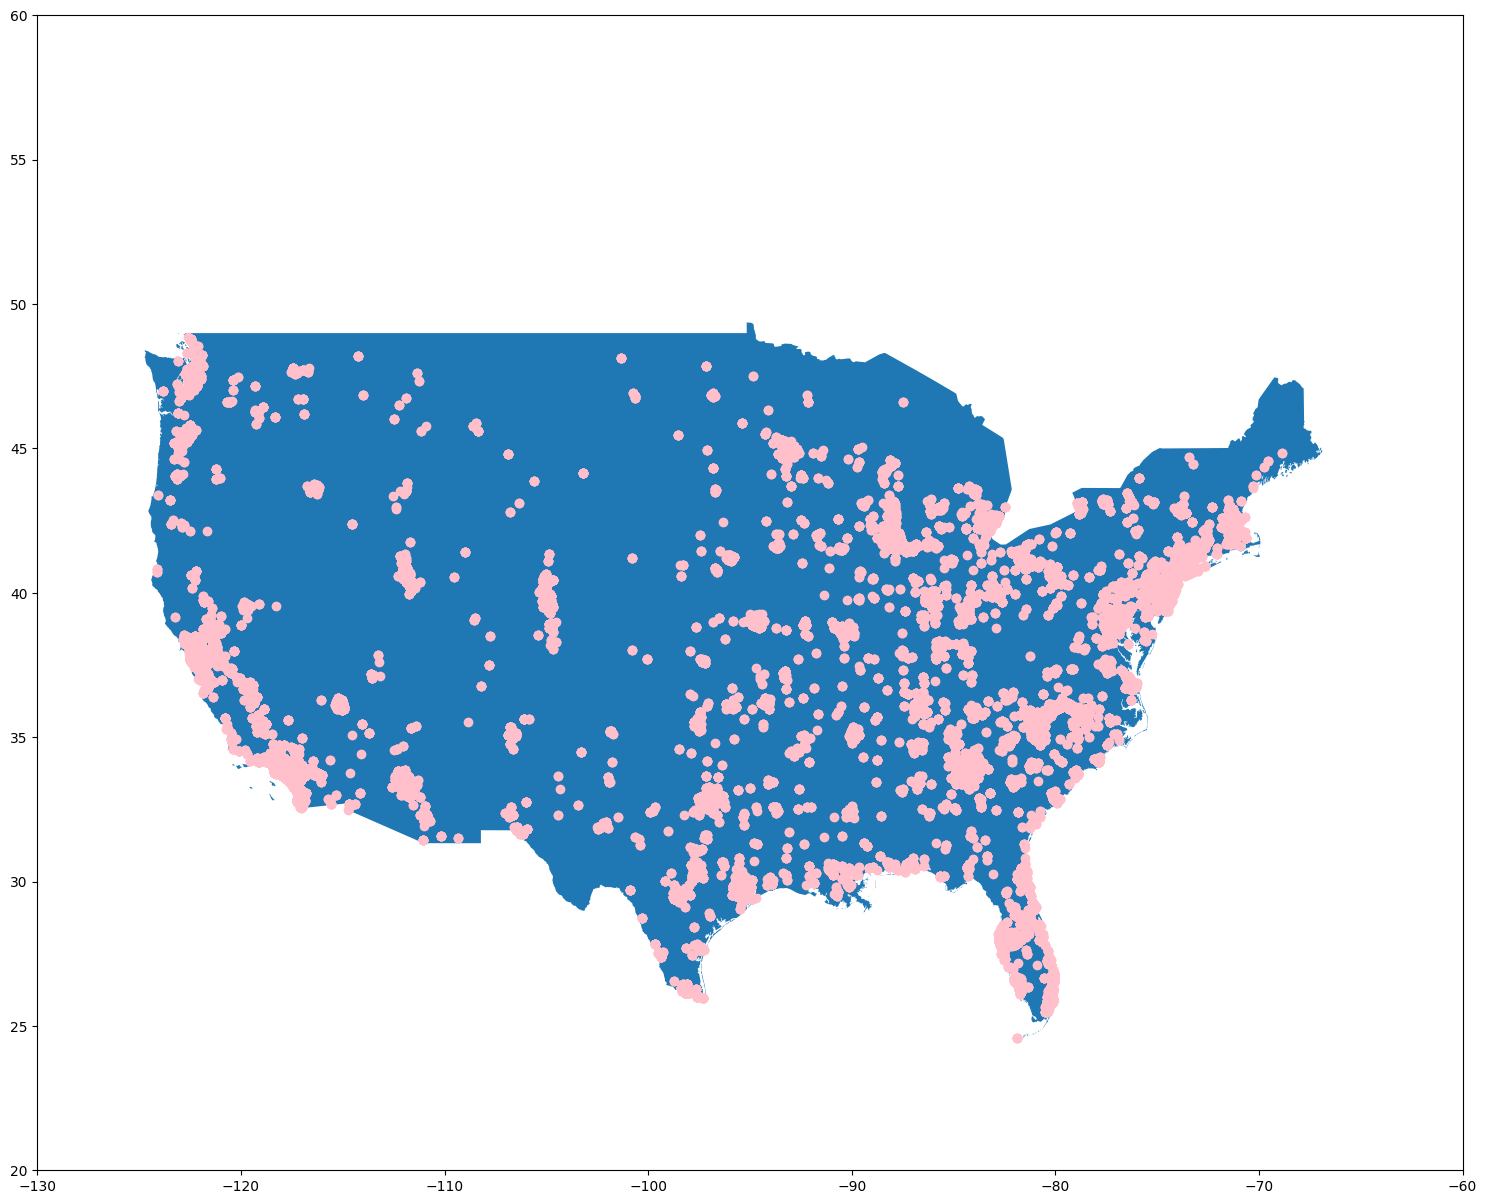

In [ ]:
# Visualize the map
fig, ax = plt.subplots(figsize=(20, 15))
map.plot(ax=ax)
ax.scatter(data['longitude'], data['latitude'], color='pink')
ax.set_xlim(-130, -60)
ax.set_ylim(20, 60)
plt.show()

## Feature Enginering


### Scaling

In [ ]:
# define scaler
scaler = StandardScaler()

# fit and transform
X = scaler.fit_transform(data[['longitude', 'latitude']])

### Finding K-Value


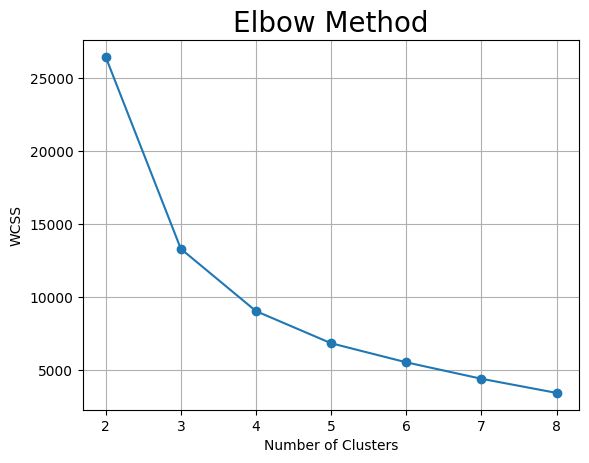

In [ ]:
wcss = []
random_state = 10
max_cluster = 8
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(X)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid()
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## Modeling

In [ ]:
# Define Model
model = KMeans(n_clusters=4, random_state=10)

## Model Training

In [ ]:
# fitting
model.fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=4, random_state=10)

## Clustering

In [ ]:
# predict
pred = model.predict(X)

# insert into original dataframe
data['cluster'] = pred

# show
data.head()

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at,cluster
0,2389,Dan,Martinez,danmartinez@example.net,53,M,Alabama,36226 Natalie Club,36608,Mobile,United States,30.680531,-88.294751,Organic,2020-08-31 07:25:00+00:00,0
1,3647,Danielle,Anderson,danielleanderson@example.com,31,F,Alabama,60522 Patrick Port Apt. 651,36608,Mobile,United States,30.680531,-88.294751,Search,2019-03-31 09:03:00+00:00,0
2,5280,Audrey,Alvarez,audreyalvarez@example.net,66,F,Alabama,31275 Veronica Knolls,36608,Mobile,United States,30.680531,-88.294751,Search,2022-06-18 15:08:00+00:00,0
3,8007,Megan,Perez,meganperez@example.net,47,F,Alabama,95116 Patrick Vista Apt. 936,36608,Mobile,United States,30.680531,-88.294751,Search,2023-09-23 15:49:00+00:00,0
4,20629,Rebecca,Henderson,rebeccahenderson@example.net,70,F,Alabama,71084 Donna Greens Apt. 802,36608,Mobile,United States,30.680531,-88.294751,Search,2021-04-02 08:33:00+00:00,0


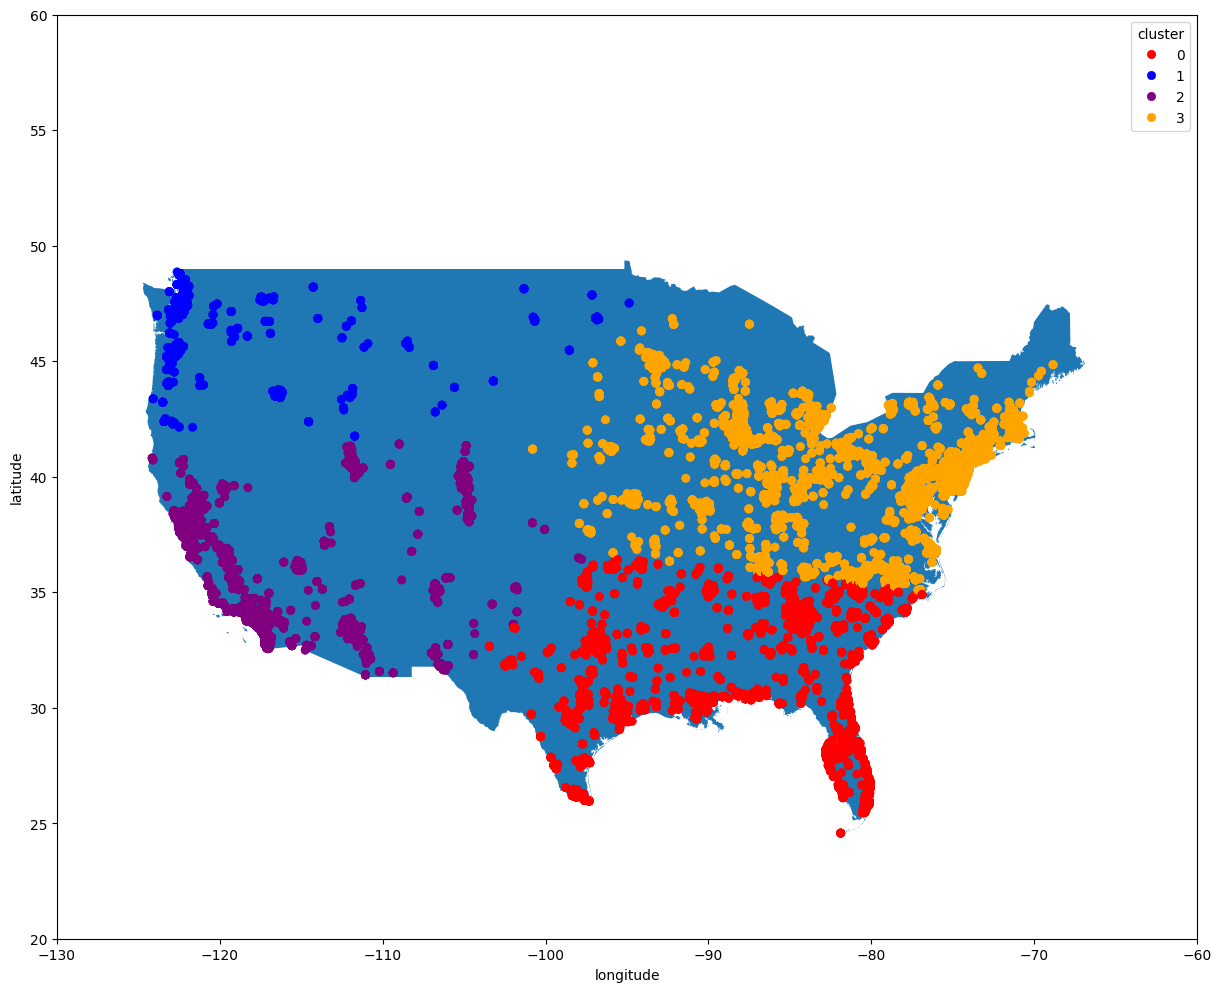

In [ ]:
# Visualize
fig, ax = plt.subplots(figsize=(15,12))

# segment color
color_dict = {0:'red', 1:'blue', 2:'purple', 3:'orange'}

# map
map.plot(ax=ax)

# data user
sns.scatterplot(x=data['longitude'], y=data['latitude'],
           hue=data['cluster'],  palette=color_dict,  edgecolors=None)

# limit canvas
ax.set_xlim(-130, -60)
ax.set_ylim(20, 60)

# show plot
plt.show()

## Get Centroid

In [ ]:
# access centroid
centroid = model.cluster_centers_

# inverse centroid location
centroid = scaler.inverse_transform(centroid)
centroid

array([[ -88.73845773,   31.07779889],
       [-120.21751159,   46.6578819 ],
       [-116.06227711,   35.65416137],
       [ -80.93325495,   40.29078284]])

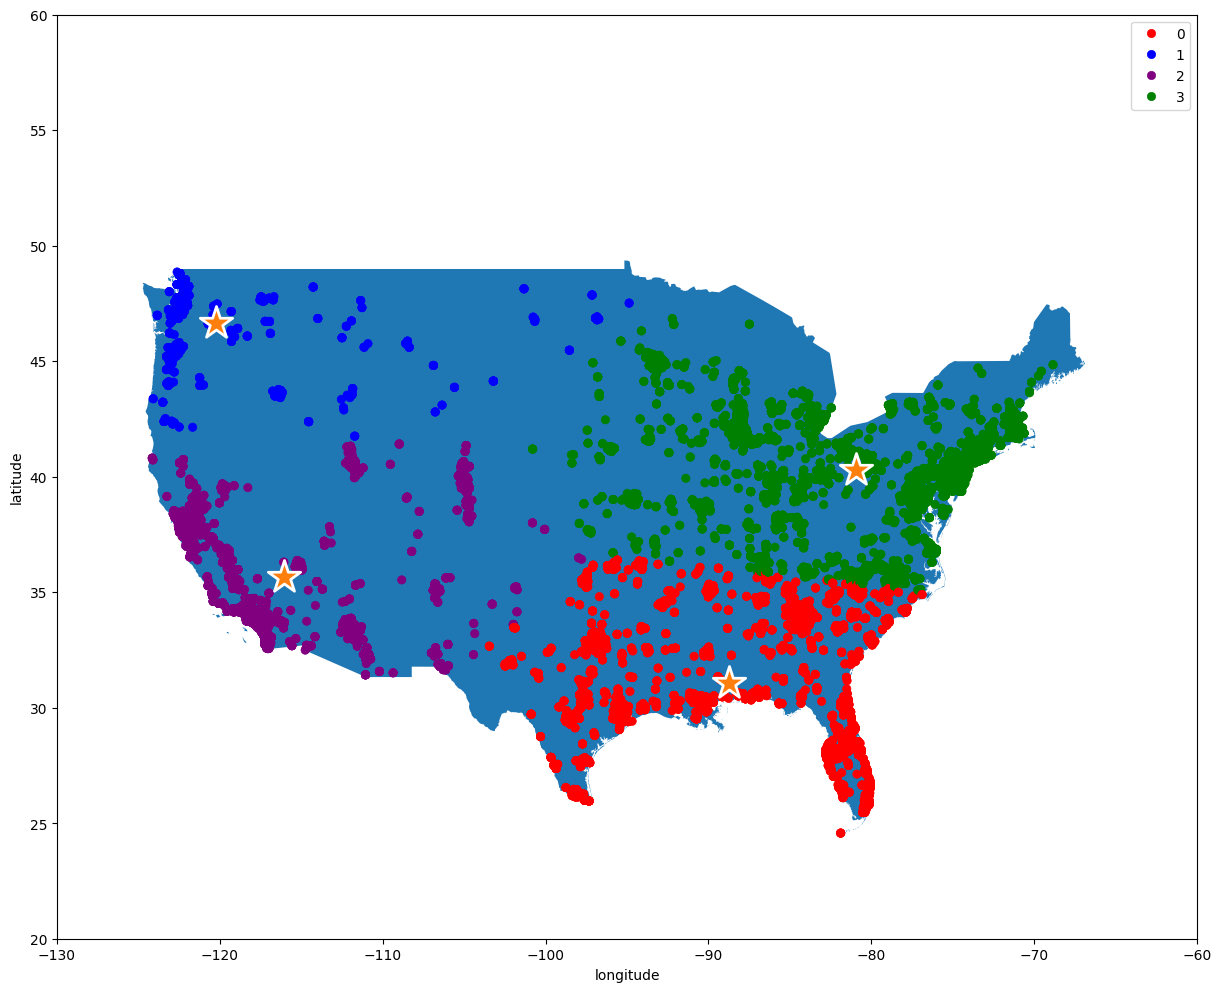

In [ ]:
# Visualize
fig, ax = plt.subplots(figsize=(15,12))

# segment color
color_dict = {0:'red', 1:'blue', 2:'purple', 3:'green'}

# map
map.plot(ax=ax)

# data user
sns.scatterplot(x=data['longitude'], y=data['latitude'],
           hue=data['cluster'],  palette=color_dict,  edgecolors=None)

# centroid
sns.scatterplot(x=centroid[:, 0], y=centroid[:, 1],
                s=600, marker='*')

# limit canvas
ax.set_xlim(-130, -60)
ax.set_ylim(20, 60)

# show plot
plt.show()

## Get Location Name

In [ ]:
# seeker
geolocator = Nominatim(user_agent='Riki')

In [ ]:
# Create Dataframe
centroid_df = pd.DataFrame(centroid, columns=['longitude', 'latitude'])

centroid_df

,longitude,latitude
0,-88.738458,31.077799
1,-120.217512,46.657882
2,-116.062277,35.654161
3,-80.933255,40.290783


In [ ]:
# search location name
centroid_df['location name'] = centroid_df.apply(
    lambda x : geolocator.reverse(f'{x.iloc[1]}, {x.iloc[0]}').raw['display_name'], axis=1)

# show
centroid_df

,longitude,latitude,location name
0,-88.738458,31.077799,"Midway Church Road, Greene County, Mississippi..."
1,-120.217512,46.657882,"Yakima County, Washington, United States"
2,-116.062277,35.654161,"San Bernardino County, California, United States"
3,-80.933255,40.290783,"Unionvale, Harrison County, Ohio, United States"
